In [3]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import normalize
import os
import torch
from torchvision import transforms
from torchvision.models import resnet18
import warnings
from PIL import Image
import pandas as pd

### Model Training

In [4]:
# Catat waktu normalisasi data
start_time = time.time()

def import_images(class_name, image_count):
    images = []
    labels = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        model = resnet18(pretrained=True)
        model = torch.nn.Sequential(*(list(model.children())[:-1]))
        model.eval()


    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    for i in range(image_count):
        image_path = "iris_dataset/iris-" + class_name + "/iris-" + class_name + "(" + str(i + 1) + ")" + ".jpg"

        # Check if the file exists
        if not os.path.exists(image_path):
            print(f"File tidak ada pada folder {image_path}. Akan diabaikan...")
            continue

        image = Image.open(image_path)
        img = transform(image).unsqueeze(0)

        with torch.no_grad():
            features = model(img)

        images.append(features.squeeze().numpy())
        labels.append(class_name)

    return images, labels

# Import images for each class
iris_setosa, labels_setosa = import_images("setosa", 67)
iris_versicolour, labels_versicolour = import_images("versicolour", 269)
iris_virginica, labels_virginica = import_images("virginica", 85)

# Combine all images into a single list
iris = iris_setosa + iris_versicolour + iris_virginica
labels = labels_setosa + labels_versicolour + labels_virginica

# Akhir normalisasi
end_time = time.time()

# Cetak waktu normalisasi
training_time = end_time - start_time
print(f'Waktu Normalisasi data: {training_time} detik')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ahmad/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:39<00:00, 1.18MB/s]


File tidak ada pada folder iris_dataset/iris-setosa/iris-setosa(65).jpg. Akan diabaikan...
File tidak ada pada folder iris_dataset/iris-setosa/iris-setosa(66).jpg. Akan diabaikan...
File tidak ada pada folder iris_dataset/iris-setosa/iris-setosa(67).jpg. Akan diabaikan...
File tidak ada pada folder iris_dataset/iris-versicolour/iris-versicolour(264).jpg. Akan diabaikan...
File tidak ada pada folder iris_dataset/iris-versicolour/iris-versicolour(265).jpg. Akan diabaikan...
File tidak ada pada folder iris_dataset/iris-versicolour/iris-versicolour(266).jpg. Akan diabaikan...
File tidak ada pada folder iris_dataset/iris-versicolour/iris-versicolour(267).jpg. Akan diabaikan...
File tidak ada pada folder iris_dataset/iris-versicolour/iris-versicolour(268).jpg. Akan diabaikan...
File tidak ada pada folder iris_dataset/iris-versicolour/iris-versicolour(269).jpg. Akan diabaikan...
File tidak ada pada folder iris_dataset/iris-virginica/iris-virginica(83).jpg. Akan diabaikan...
File tidak ada pad

### Keseimbangan Data (Oversample)

In [5]:
def oversample(data, labels):
    df = pd.DataFrame(data)
    df['labels'] = labels

    # Mendapatkan kelas mayoritas.
    majority_class = df['labels'].mode()[0]

    # Mendapatkan jumlah data dari setiap kelas.
    class_counts = df['labels'].value_counts()
    
    # Mengambil data dari kelas minoritas.
    minority_data = df[df['labels'] != majority_class]

    # Duplikasi data dari kelas minoritas.
    oversampled_data = pd.concat([df, minority_data.sample(n=class_counts[majority_class] - class_counts.min(), replace=True)])
    
    return oversampled_data.iloc[:, :-1].values, oversampled_data['labels'].values, majority_class


iris, labels, majority_class = oversample(iris, labels)

### Akurasi Data Train dan Uji

In [6]:
from sklearn.model_selection import KFold

start_time = time.time()

# Memisahkan fitur dan label
X = np.array(iris)
y = np.array(labels)

# Inisialisasi model Decision Tree
clf = DecisionTreeClassifier()

# Inisialisasi KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

accuracies_train = []
accuracies_test = []
split_number = 0

# Melakukan cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Normalize 
    X_train = normalize(X_train)
    X_test = normalize(X_test)

    # Pelatihan model pada data pelatihan
    clf.fit(X_train, y_train)

    # Prediksi pada data pelatihan
    y_train_pred = clf.predict(X_train)
    accuracies_train.append(accuracy_score(y_train, y_train_pred))
    print(f"Akurasi Train pada split {split_number + 1} {accuracies_train}")

    # Prediksi pada data uji
    y_test_pred = clf.predict(X_test)
    accuracies_test.append(accuracy_score(y_test, y_test_pred))
    print(f"Akurasi Test pada split {split_number + 1} {accuracies_test}\n")
    split_number += 1

# Menghitung rata-rata akurasi
average_accuracy_train = sum(accuracies_train) / len(accuracies_train)
average_accuracy_test = sum(accuracies_test) / len(accuracies_test)

print(f'Rata-rata Akurasi Pelatihan: {average_accuracy_train}')
print(f'Rata-rata Akurasi Uji: {average_accuracy_test}')

end_time = time.time()

training_time = end_time - start_time
print(f'Waktu Train data: {training_time} detik')

Akurasi Train pada split 1 [0.9725776965265083]
Akurasi Test pada split 1 [0.8032786885245902]

Akurasi Train pada split 2 [0.9725776965265083, 0.979890310786106]
Akurasi Test pada split 2 [0.8032786885245902, 0.6557377049180327]

Akurasi Train pada split 3 [0.9725776965265083, 0.979890310786106, 0.9762340036563071]
Akurasi Test pada split 3 [0.8032786885245902, 0.6557377049180327, 0.7540983606557377]

Akurasi Train pada split 4 [0.9725776965265083, 0.979890310786106, 0.9762340036563071, 0.9725776965265083]
Akurasi Test pada split 4 [0.8032786885245902, 0.6557377049180327, 0.7540983606557377, 0.819672131147541]

Akurasi Train pada split 5 [0.9725776965265083, 0.979890310786106, 0.9762340036563071, 0.9725776965265083, 0.9725776965265083]
Akurasi Test pada split 5 [0.8032786885245902, 0.6557377049180327, 0.7540983606557377, 0.819672131147541, 0.7704918032786885]

Akurasi Train pada split 6 [0.9725776965265083, 0.979890310786106, 0.9762340036563071, 0.9725776965265083, 0.9725776965265083,

### Testing Image

Ini bagian Setosa


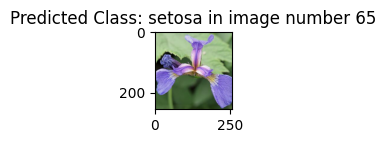

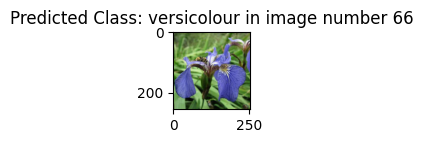

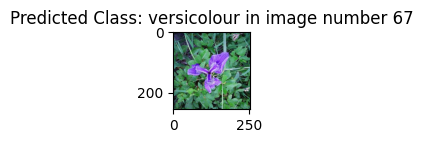

Ini bagian Versicolour


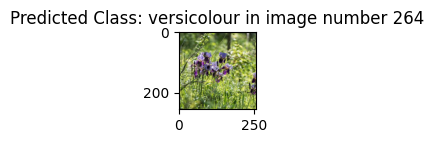

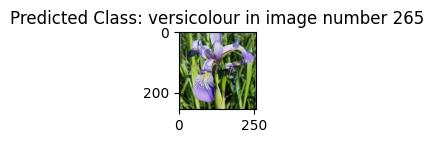

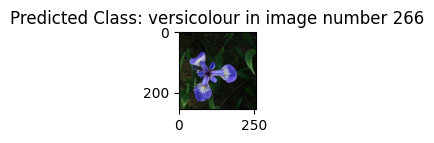

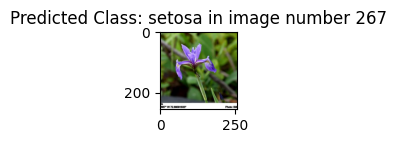

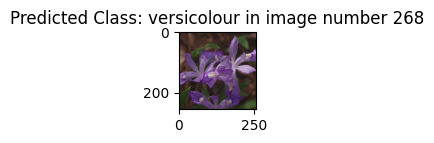

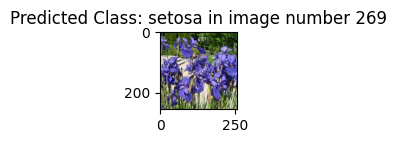

Ini bagian Virginica


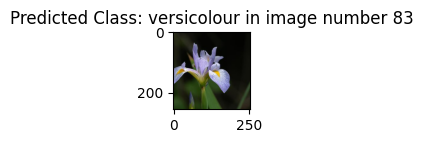

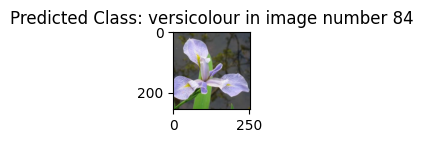

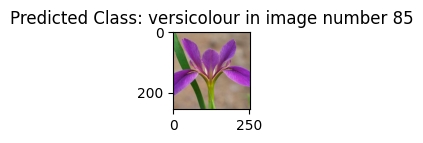

In [7]:
# Make a prediction     
def class_test_image(class_test, max_number_image, boundaries_image):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        model = resnet18(pretrained=True)
        model = torch.nn.Sequential(*(list(model.children())[:-1]))
        model.eval()


    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    while boundaries_image <= max_number_image:
        image_path = f"iris_data_uji_coba/iris-{class_test}/iris-{class_test}({boundaries_image}).jpg"

        image = Image.open(image_path)
        img = transform(image).unsqueeze(0)

        with torch.no_grad():
            features = model(img)

        # Convert features to a numpy array
        features_np = features.squeeze().numpy()

        # Normalize the features
        features_normalized = normalize(features_np.reshape(1, -1), axis=1, norm="l2")

        # Make a prediction using the trained classifier (clf)
        prediction = clf.predict(features_normalized)
        
        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.title(f"Predicted Class: {prediction[0]} in image number {boundaries_image}")
        plt.show()
        boundaries_image += 1

print("Ini bagian Setosa")
class_test_image("setosa", 67, 65)
print("Ini bagian Versicolour")
class_test_image("versicolour", 269, 264)
print("Ini bagian Virginica")
class_test_image("virginica", 85, 83)


### Report and Visualization

In [56]:
# Print classification report

# Data Uji
expected = y_test
predicted = y_test_pred

class_report = metrics.classification_report(expected, predicted)
print("Classification Report pada Data Uji:\n")
print(class_report)

# Data Train
expected = y_train
predicted = y_train_pred

class_report = metrics.classification_report(expected, predicted)
print("\nClassification Report pada Data Train:\n")
print(class_report)

Classification Report pada Data Uji:

              precision    recall  f1-score   support

      setosa       0.93      1.00      0.96        26
 versicolour       0.86      0.62      0.72        29
   virginica       0.77      0.91      0.83        33

    accuracy                           0.84        88
   macro avg       0.85      0.84      0.84        88
weighted avg       0.85      0.84      0.83        88


Classification Report pada Data Train:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00       249
 versicolour       0.99      0.95      0.97       269
   virginica       0.96      0.99      0.97       278

    accuracy                           0.98       796
   macro avg       0.98      0.98      0.98       796
weighted avg       0.98      0.98      0.98       796



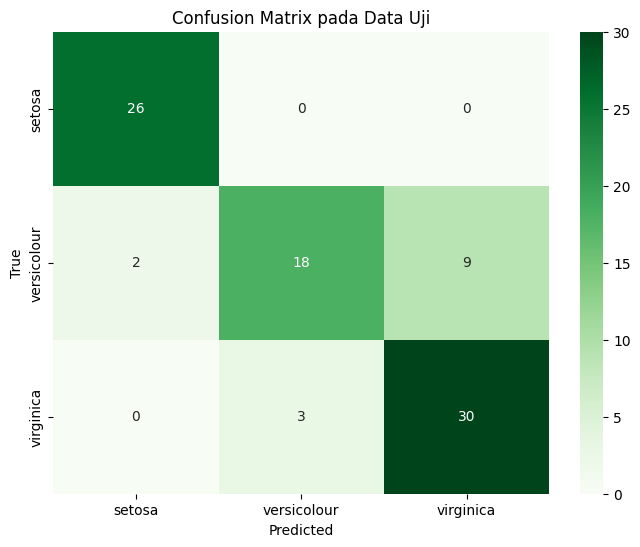

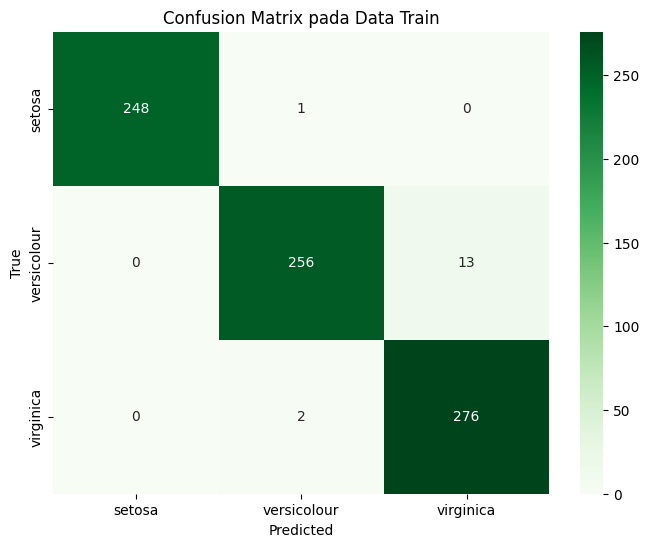

In [57]:
#Data Uji
conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['setosa', 'versicolour', 'virginica'],
            yticklabels=['setosa', 'versicolour', 'virginica'])
plt.title('Confusion Matrix pada Data Uji')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Data Train
conf_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens', xticklabels=['setosa', 'versicolour', 'virginica'],
            yticklabels=['setosa', 'versicolour', 'virginica'])
plt.title('Confusion Matrix pada Data Train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

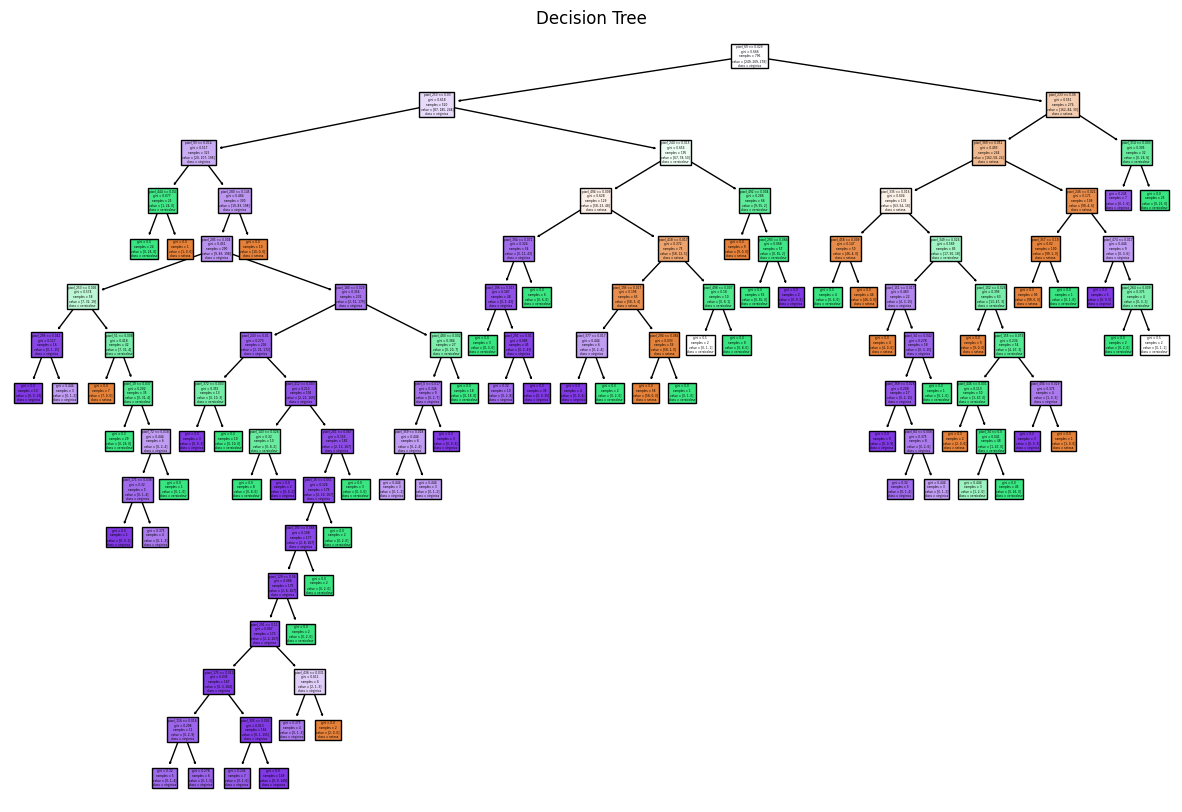

In [58]:
# Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=[f'pixel_{i}' for i in range(X.shape[1])], class_names=['setosa', 'versicolour', 'virginica'])
plt.title('Decision Tree')
plt.show()

## Mencari Optimalisasi Decision Tree

### Cari Hyperparameter yang optimal

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

param_dist = {'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30],
              'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30]}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=30, cv=2, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)


Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 17}


### Cari Depth yang Optimal

In [37]:
# Catat waktu train data
start_time = time.time()

from sklearn.model_selection import KFold

test_depth = 1

while (test_depth <= 20):
    clf = DecisionTreeClassifier(max_depth=test_depth)
    
    # Define the number of folds
    n_splits = 5
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Create lists 
    accuracies = []
    
    # K-Fold cross-validation
    for train_index, test_index in kf.split(X):
    
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
    
        clf.fit(X_train_fold, y_train_fold)
    
        y_pred = clf.predict(X_test_fold)
    
        accuracies.append(accuracy_score(y_test_fold, y_pred))
    
    average_accuracy = np.mean(accuracies)
    print(f'Average Accuracy pada depth {test_depth}: {average_accuracy}')
    test_depth = test_depth + 1

# Akhir train
end_time = time.time()

# Cetak waktu train
training_time = end_time - start_time
print(f'Waktu Train data: {training_time} detik')

Average Accuracy pada depth 1: 0.5056041181041181
Average Accuracy pada depth 2: 0.5877719502719503
Average Accuracy pada depth 3: 0.6448912198912199
Average Accuracy pada depth 4: 0.6783022533022532
Average Accuracy pada depth 5: 0.7131313131313132
Average Accuracy pada depth 6: 0.7409965034965034
Average Accuracy pada depth 7: 0.7563034188034188
Average Accuracy pada depth 8: 0.7590714840714841
Average Accuracy pada depth 9: 0.7883255633255634
Average Accuracy pada depth 10: 0.8064685314685315
Average Accuracy pada depth 11: 0.8009226884226883
Average Accuracy pada depth 12: 0.7994755244755245
Average Accuracy pada depth 13: 0.7953088578088578
Average Accuracy pada depth 14: 0.7967074592074593
Average Accuracy pada depth 15: 0.7841783216783217
Average Accuracy pada depth 16: 0.7869755244755245
Average Accuracy pada depth 17: 0.7883352758352757
Average Accuracy pada depth 18: 0.7994949494949496
Average Accuracy pada depth 19: 0.8106351981351981
Average Accuracy pada depth 20: 0.786936